In [1]:
import pandas as pd
import os


base_path = "data"


all_regions_data = []


for region_id in range(1, 7):
    region_path = os.path.join(base_path, str(region_id))
    
    
    region_data = []
    
    
    for file_id in range(1, 8): 
        file_path = os.path.join(region_path, f"{file_id}.xlsx")
        
        
        df = pd.read_excel(file_path, skiprows=2)
        if(file_id==5 or file_id==2):
            
           df = df.replace(r'\*', '', regex=True)
        
    
        
        if file_id == 7:
            df = df.fillna(0)
        
        
        
        if file_id == 1:
            df['source'] = "Температура воздуха"
        elif file_id == 2:
            df['source'] = "Температура почвы"
        elif file_id == 3:
            df['source'] = "Относительная влажность"
        elif file_id == 4:
            df['source'] = "Давление"
        elif file_id == 5:
            df['source'] = "Облачность"
        elif file_id == 6:
            df['source'] = "Скорость ветра"
        elif file_id == 7:
            df['source'] = "Осадки"
        
        
        region_data.append(df)
    
    
    region_df = pd.concat(region_data, ignore_index=True)
    region_df['region_id'] = region_id  
    
    
    all_regions_data.append(region_df)

final_data = pd.concat(all_regions_data, ignore_index=True)

final_data.to_csv("combined_data.csv", index=False)

print("'combined_data.csv'. created")


'combined_data.csv'. created


In [2]:
import pandas as pd

df = pd.read_csv('combined_data.csv')
columns_to_convert = ['18', '21', '00', '03', '06', '09', '12', '15']

for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce')


In [3]:
import pandas as pd

harvest_data = {
    "region_id": [1, 2, 3, 4, 5, 6],
    "harvest_2021": [103046.0, 49928.0, 302894.1, 305600.0, 559656.2, 231486.1],
    "harvest_2022": [103634.3, 50202.8, 310000.0, 320020.0, 246237.6, 169280.0],
    "area_2021": [548.5, 267.0, 1600.0, 1598.5, 2640.0, 1345.0],
    "area_2022": [548.5, 267.0, 1600.7, 1600.1, 1239.0, 920.0]
}

harvest_df = pd.DataFrame(harvest_data)

harvest_df.to_csv("harvest_data.csv", index=False)

print("'harvest_data.csv' created.")


'harvest_data.csv' created.


In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

meteorological_data = pd.read_csv("combined_data.csv")
harvest_data = pd.read_csv("harvest_data.csv")

meteorological_data['date'] = pd.to_datetime(meteorological_data['date'])
meteorological_data['month'] = meteorological_data['date'].dt.month
meteorological_data = meteorological_data[(meteorological_data['month'] >= 4) & (meteorological_data['month'] <= 9)]



In [5]:

hours = ['18', '21', '00', '03', '06', '09', '12', '15']
sum = int(0)
for hour in hours:
    sum+=pd.to_numeric(meteorological_data[hour])
meteorological_data['value'] = sum/8



In [6]:
seasonal_data = meteorological_data.groupby(['region_id', 'source'])['value'].mean().reset_index()



seasonal_pivot = seasonal_data.pivot(index='region_id', columns='source', values='value').reset_index()

data_2021 = harvest_data[['region_id', 'harvest_2021', 'area_2021']].merge(seasonal_pivot, on='region_id', how='left')
data_2022 = harvest_data[['region_id', 'harvest_2022', 'area_2022']].merge(seasonal_pivot, on='region_id', how='left')


data_2021['yield_2021'] = data_2021['harvest_2021'] / data_2021['area_2021']
data_2022['yield_2022'] = data_2022['harvest_2022'] / data_2022['area_2022']


X_train = data_2021.drop(columns=['region_id', 'harvest_2021', 'area_2021', 'yield_2021'])
y_train = data_2021['yield_2021']

X_test = data_2022.drop(columns=['region_id', 'harvest_2022', 'area_2022', 'yield_2022'])
y_test = data_2022['yield_2022']


model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Grade a model:")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


results = pd.DataFrame({
    'region_id': data_2022['region_id'],
    'actual_yield_2022': y_test,
    'predicted_yield_2022': y_pred
})
results.to_csv("predicted_yield_2022.csv", index=False)

print("results:'predicted_yield_2022.csv'.")


Grade a model:
MAE: 4.924378345451122
RMSE: 5.796448342257642
R²: -0.0028183227709939196
results:'predicted_yield_2022.csv'.


In [7]:
tree = model.estimators_[0]  # Первое дерево


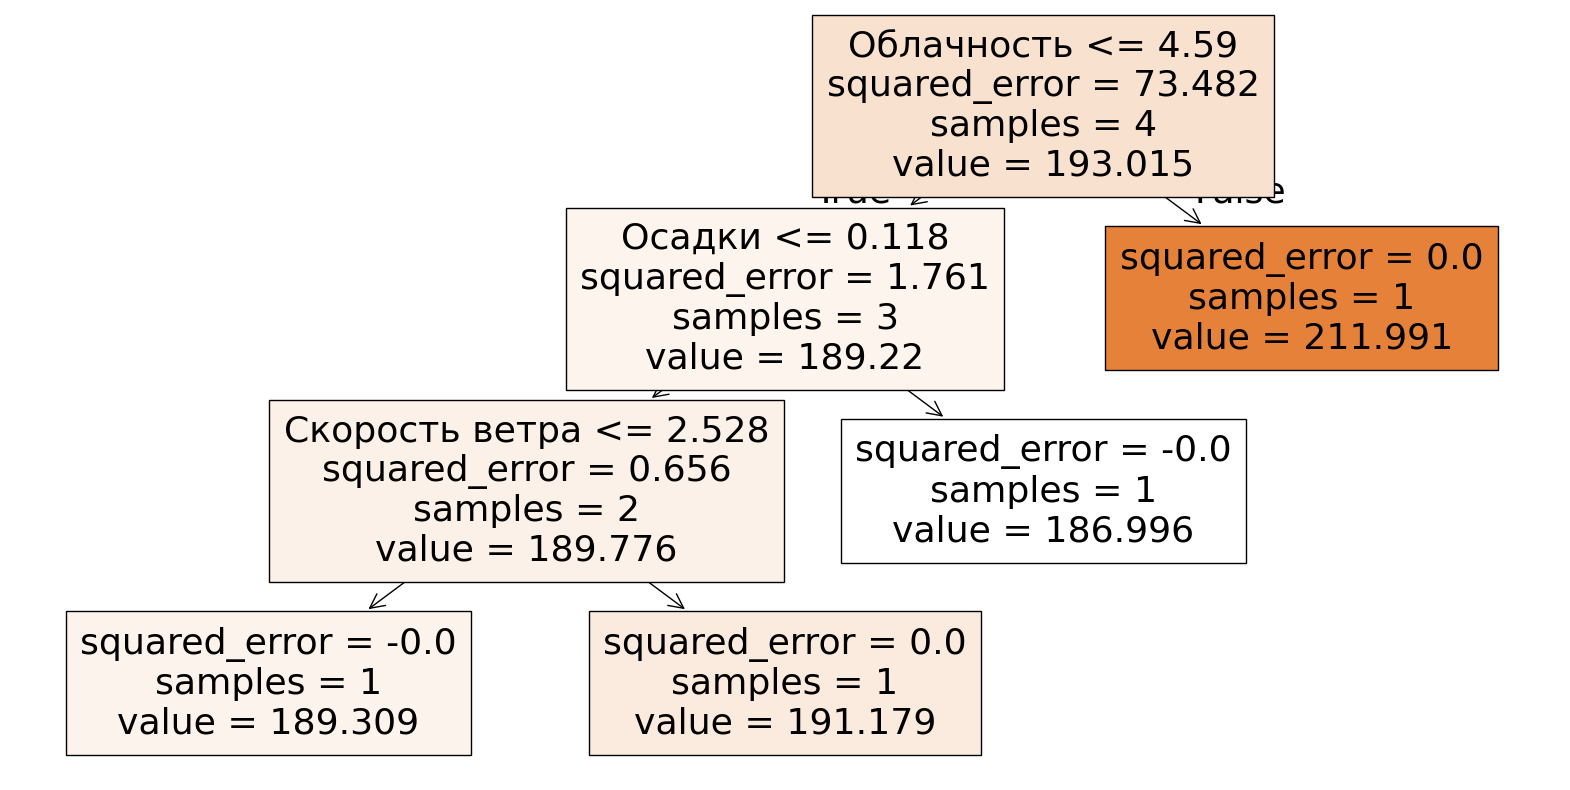

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X_train.columns, filled=True)
plt.show()
